In [1]:
! pip3 install pandas pycoingecko matplotlib scipy
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import datetime as dt
import time
import statistics as stats
import numpy as np
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [11]:
tweet_date = "2018-07-18 01:58:00"
coin='dogecoin'
date_format = "%Y-%m-%d %H:%M:%S"
#1 day from current time will produce 5min interval
#1-90 hourly interval
#above 90 days is daily
number_of_days = 3
number_of_hours = 0
tweet_datetime = pd.to_datetime(tweet_date,format=date_format)
tweet_from_timestamp = (tweet_datetime - dt.timedelta(days=number_of_days,hours=number_of_hours)).timestamp()
tweet_to_timestamp = (tweet_datetime + dt.timedelta(days=number_of_days,hours=number_of_hours)).timestamp()

In [12]:
coin_gecko_data = cg.get_coin_market_chart_range_by_id(id=coin,
                                                vs_currency='usd',
                                                from_timestamp=tweet_from_timestamp,
                                                to_timestamp=tweet_to_timestamp)

In [13]:
def get_nth_element():
    return l[1]
parsed_data = {}
timestamps=list(map(lambda x:x[0],coin_gecko_data['prices']))
for key in coin_gecko_data.keys():
    parsed_data[key] = list(map(lambda x:x[1], coin_gecko_data[key]))
parsed_data['timestamps']=timestamps

In [14]:
df=pd.DataFrame(parsed_data)

In [15]:
df

,prices,market_caps,total_volumes,timestamps
0,0.002318,2.672272e+08,2.161225e+06,1531621891626
1,0.002319,2.673310e+08,1.943938e+06,1531625491017
2,0.002325,2.679885e+08,1.871403e+06,1531629090676
3,0.002328,2.683398e+08,1.815906e+06,1531632691482
4,0.002331,2.686644e+08,1.678754e+06,1531636291001
...,...,...,...,...
145,0.003409,3.933192e+08,1.646972e+07,1532120415458
146,0.003398,3.919997e+08,1.688406e+07,1532124014841
147,0.003451,3.981536e+08,1.737161e+07,1532127613219
148,0.003427,3.953931e+08,1.698728e+07,1532131211775


In [16]:
df['timestamps'].head()

0    1531621891626
1    1531625491017
2    1531629090676
3    1531632691482
4    1531636291001
Name: timestamps, dtype: int64

In [17]:
df['date']=pd.to_datetime(df['timestamps'],origin='unix',unit='ms')

In [18]:
df

,prices,market_caps,total_volumes,timestamps,date
0,0.002318,2.672272e+08,2.161225e+06,1531621891626,2018-07-15 02:31:31.626
1,0.002319,2.673310e+08,1.943938e+06,1531625491017,2018-07-15 03:31:31.017
2,0.002325,2.679885e+08,1.871403e+06,1531629090676,2018-07-15 04:31:30.676
3,0.002328,2.683398e+08,1.815906e+06,1531632691482,2018-07-15 05:31:31.482
4,0.002331,2.686644e+08,1.678754e+06,1531636291001,2018-07-15 06:31:31.001
...,...,...,...,...,...
145,0.003409,3.933192e+08,1.646972e+07,1532120415458,2018-07-20 21:00:15.458
146,0.003398,3.919997e+08,1.688406e+07,1532124014841,2018-07-20 22:00:14.841
147,0.003451,3.981536e+08,1.737161e+07,1532127613219,2018-07-20 23:00:13.219
148,0.003427,3.953931e+08,1.698728e+07,1532131211775,2018-07-21 00:00:11.775


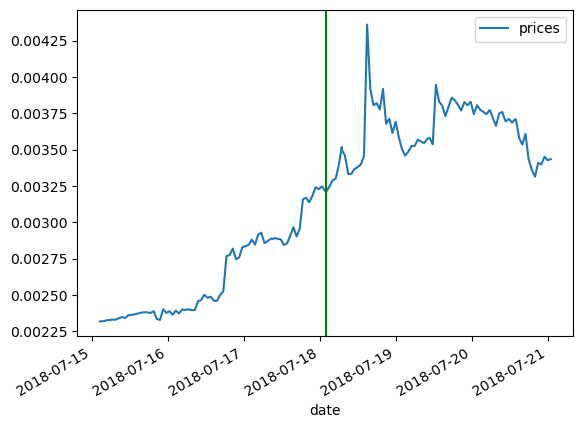

In [19]:
df.plot(x='date',y='prices')
plt.axvline(tweet_datetime,color='green')

In [23]:
df_before =df[df['date'] < tweet_datetime]

In [24]:
df_after = df[df['date']> tweet_datetime]

In [25]:
df_before.describe()

,prices,market_caps,total_volumes,timestamps
count,74.000000,7.400000e+01,7.400000e+01,7.400000e+01
mean,0.002643,3.047812e+08,9.723455e+06,1.531752e+12
std,0.000297,3.433314e+07,7.923979e+06,7.520755e+07
min,0.002318,2.672272e+08,1.675606e+06,1.531622e+12
25%,0.002377,2.740121e+08,2.112446e+06,1.531688e+12
50%,0.002494,2.876275e+08,4.857307e+06,1.531753e+12
75%,0.002882,3.323443e+08,1.776300e+07,1.531815e+12
max,0.003248,3.745164e+08,2.270148e+07,1.531878e+12


In [26]:
df_after.describe()

,prices,market_caps,total_volumes,timestamps
count,76.000000,7.600000e+01,7.600000e+01,7.600000e+01
mean,0.003616,4.171134e+08,2.750743e+07,1.532006e+12
std,0.000204,2.351836e+07,1.119412e+07,7.637130e+07
min,0.003209,3.701001e+08,1.311440e+07,1.531879e+12
25%,0.003454,3.983855e+08,1.758460e+07,1.531939e+12
50%,0.003611,4.165723e+08,2.396601e+07,1.532006e+12
75%,0.003771,4.349417e+08,3.981859e+07,1.532073e+12
max,0.004360,5.029156e+08,4.894532e+07,1.532135e+12
